#  Прогнозирование заказов такси

Таксопарк собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

## Подготовка

### Имортируем все необходимые инструмены

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import statistics
from scipy import stats as st
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import (
    DummyRegressor,
    DummyClassifier
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    mean_squared_error, 
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    recall_score,
    precision_score,
    make_scorer,
    mean_absolute_error
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    TimeSeriesSplit
)
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler
)
from lightgbm import LGBMRegressor
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor
)
from statsmodels.tsa.seasonal import (
    seasonal_decompose
)

### Загрузим данные и созданим временной ряд

In [2]:
try:
    data = pd.read_csv("taxi.csv", index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.sort_index(inplace=True)

### Откроем первые 5 строк таблицы

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Посмотрим колличество данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Проверим данные на пропуски

In [6]:
data.isna().sum()

num_orders    0
dtype: int64

## Анализ

### Ресемплирование

**Так как мы исследуем работу такси, лучше интервал использовать в 1 час**

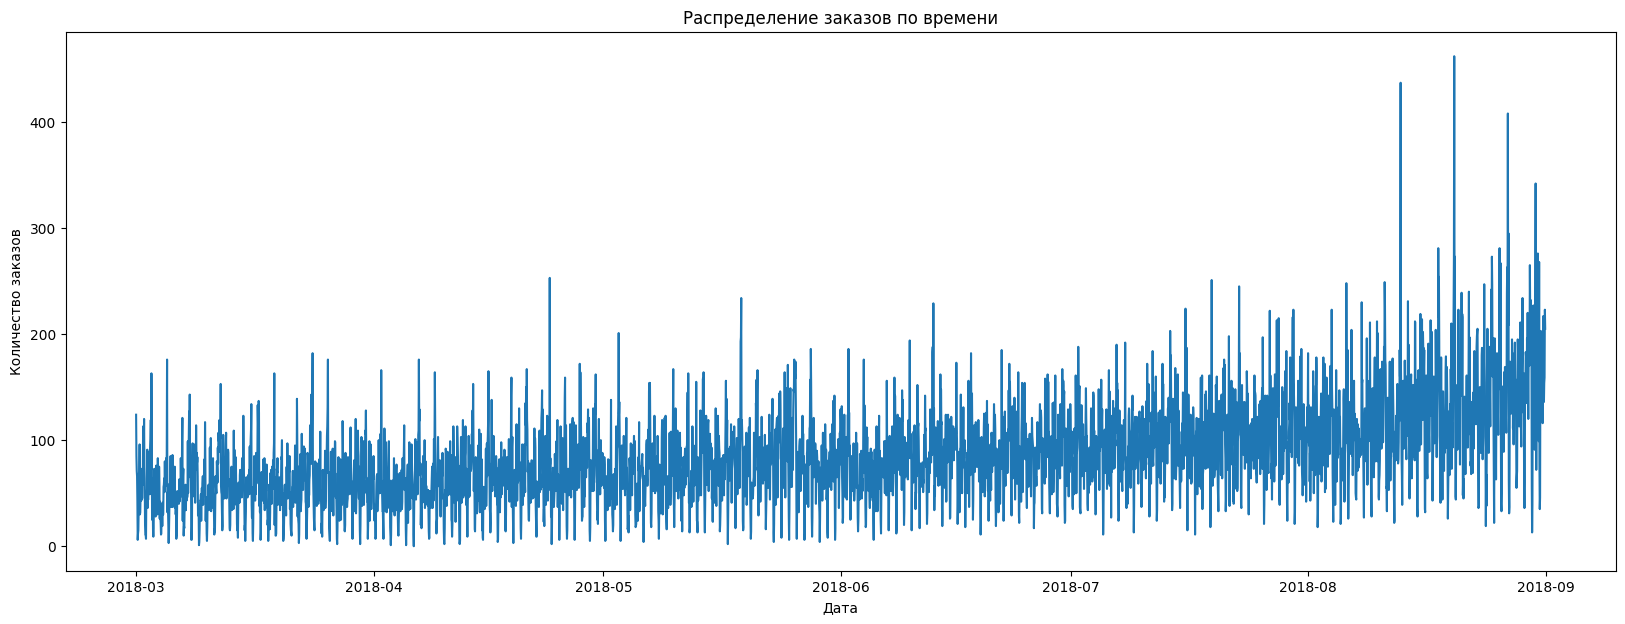

In [7]:
data = data.resample('1H').sum()
plt.figure(figsize=(20, 7))
plt.plot(data)
plt.title('Распределение заказов по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

### Декомпозиция и анализ временных рядов

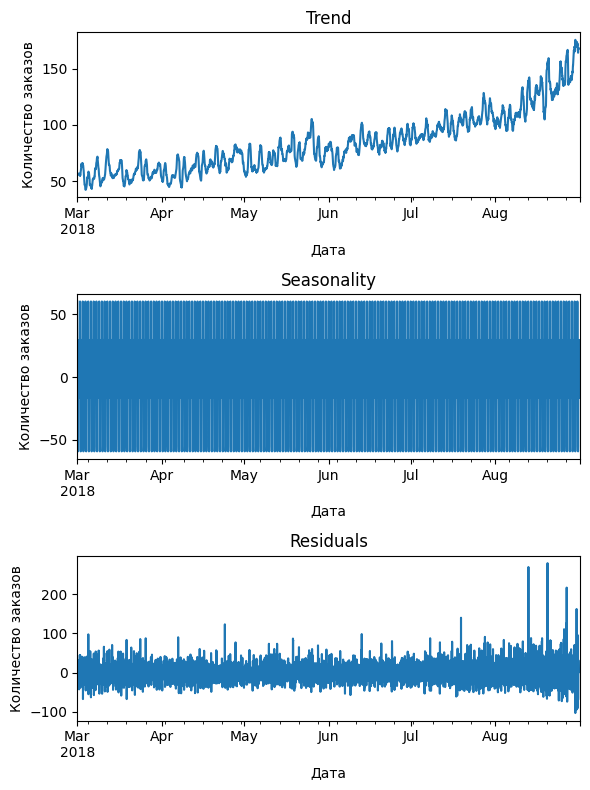

In [8]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

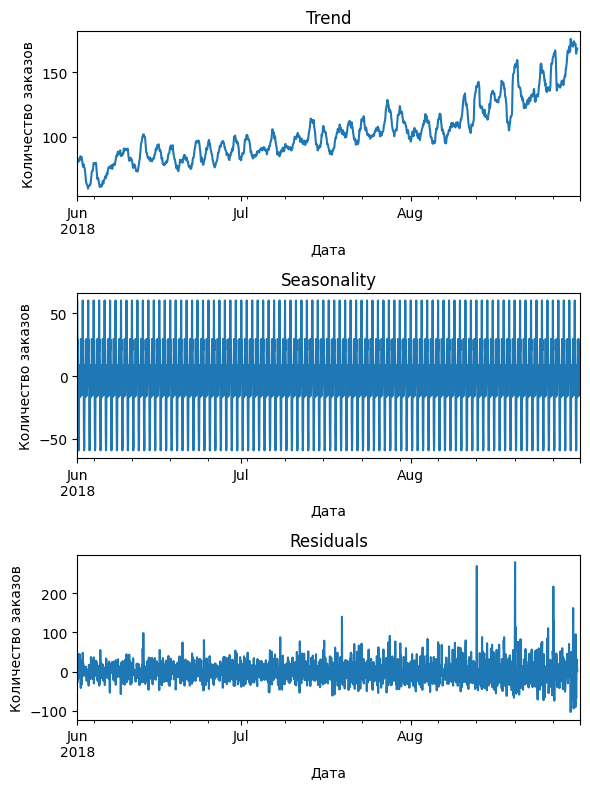

In [9]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-06-01' : '2018-09-01'].plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal['2018-06-01' : '2018-09-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.subplot(313)
decomposed.resid['2018-06-01' : '2018-09-01'].plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

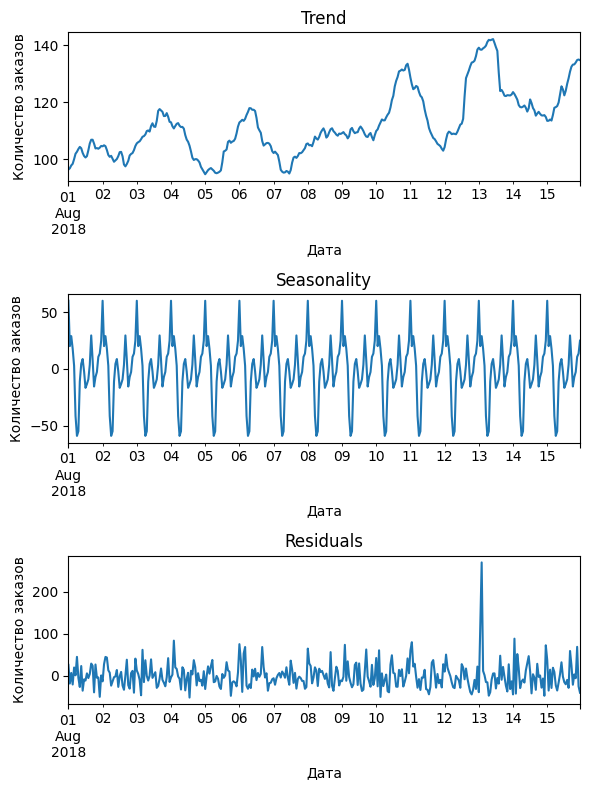

In [10]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-08-01' : '2018-08-15'].plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal['2018-08-01' : '2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid['2018-08-01' : '2018-08-15'].plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

**Видим тренд на повышение, что говорит о том, что дела у таксопарка идут в гору, сезонность не смотрели, так как данные только за малый период времени**

### Скользящее среднее и скользящее стандартное отклонение

<AxesSubplot: xlabel='datetime'>

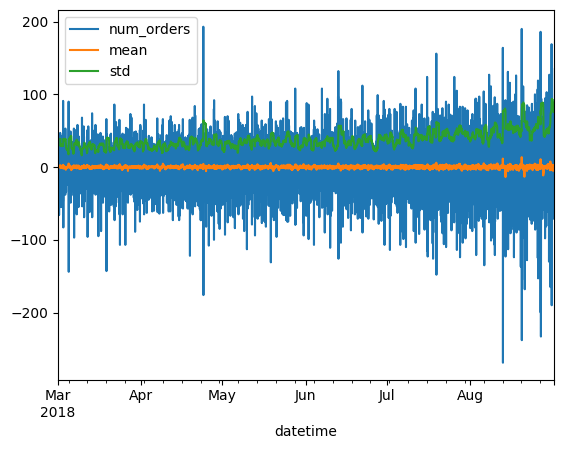

In [11]:
data_sm = data - data.shift(fill_value=0)
data_sm['mean'] = data_sm['num_orders'].rolling(24).mean()
data_sm['std'] = data_sm['num_orders'].rolling(24).std()
data_sm.plot()

**Прогнозировать данные нам помогут стационарные ряды. Стохастический процесс нестационарный, так как меняется стандартное отклонение. Для лучшего предсказания данных все значения тестовой выборки предсказываются одним и тем же константой равной среднему.**

### Создание новых признаков

**Используем скользящее среднее для создания новых признаков. Создадим 4 колонки с лагами, а так же днём, неделей и 24 часовым интервалом**

In [12]:
data_new = data.copy()
def make_features(data_new, max_lag, rolling_mean_size):
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
make_features(data_new, 4, 24)

### Разделение данных

In [13]:
#train, validate, test = \
#              np.split(data.sample(frac=1, random_state=12345), 
#                       [int(.7*len(data)), int(.9*len(data))])

In [14]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
#target_valid = validate['num_orders']
#features_valid = validate.drop('num_orders', axis=1)
test_target = test['num_orders']
test_features = test.drop('num_orders', axis=1)

**Создадим функцию для разбивание временных рядов на выборки на 24 части**

In [16]:
def time_series_split (model, train_data):
    tscv = TimeSeriesSplit(n_splits = 24, max_train_size=train_data.shape[0])
    rmse = 0
    for train_index, test_index in tscv.split(train_data):
        for train, test in tscv.split(train_data):
            train = train_data.iloc[train_index]
            test = train_data.iloc[test_index]
            target_train = train['num_orders']
            features_train = train.drop('num_orders', axis=1)
            test_target = test['num_orders']
            test_features = test.drop('num_orders', axis=1)
            model.fit(features_train, target_train)
            predictions = model.predict(test_features)
            rmse += mean_squared_error(test_target, predictions)**0.5
        return rmse / 24

## Обучение

### Модель линейной регрессии

In [17]:
model = LinearRegression()
model_lin = time_series_split(model=model, train_data=train)
print("RMSE модели линейной регрессии на тренировочной выборке:", model_lin)

RMSE модели линейной регрессии на тренировочной выборке: 22.443927318464095


**RMSE у линейной регрессии 22.44**

### Модель случайного леса

In [18]:
best_result = 60
best_depth = 0
best_split = 0
for depth in range(1, 9):
    for split in range(10, 90, 10):
        model = RandomForestRegressor(
            random_state=12345,
            max_depth=depth,
            min_samples_split=split,
            min_samples_leaf=10
            )
        model_forest = time_series_split(model=model, train_data=train)
        if best_result > model_forest:
            best_result = model_forest
            best_depth = depth
            best_split = split
print(best_result)
print(best_depth)
print(best_split)

18.884809657316467
7
10


In [19]:
model_forest = RandomForestRegressor(
            random_state=12345,
            max_depth=7,
            min_samples_split=10,
            min_samples_leaf=10
            )

**RMSE у модели случайного леса 18.88**

### Модель CatBoostRegressor

In [20]:
best_result = 60
best_depth = 0
best_iterations = 0
for depth in range(6, 9, 1):
    for iterations_i in range(300, 400, 100):
        model = CatBoostRegressor(
                                      random_state=12345,
                                      iterations=iterations_i,
                                      learning_rate=0.05,
                                      depth = depth
                                      )
        model_cat = time_series_split(model=model, train_data=train)
        if best_result > model_cat:
            best_result = model_cat
            best_depth = depth
            best_iterations = iterations_i
print(best_result)
print(best_depth)
print(best_iterations)

0:	learn: 29.5837156	total: 143ms	remaining: 42.7s
1:	learn: 28.9653837	total: 143ms	remaining: 21.4s
2:	learn: 28.5272386	total: 144ms	remaining: 14.2s
3:	learn: 28.1525419	total: 144ms	remaining: 10.7s
4:	learn: 27.6566433	total: 145ms	remaining: 8.54s
5:	learn: 27.1477139	total: 145ms	remaining: 7.11s
6:	learn: 26.7226086	total: 146ms	remaining: 6.11s
7:	learn: 26.4630341	total: 146ms	remaining: 5.35s
8:	learn: 26.0168212	total: 147ms	remaining: 4.75s
9:	learn: 25.6161920	total: 148ms	remaining: 4.28s
10:	learn: 25.3033834	total: 148ms	remaining: 3.89s
11:	learn: 24.9251570	total: 149ms	remaining: 3.57s
12:	learn: 24.5967601	total: 149ms	remaining: 3.29s
13:	learn: 24.1736151	total: 150ms	remaining: 3.06s
14:	learn: 23.8986781	total: 151ms	remaining: 2.86s
15:	learn: 23.6174261	total: 152ms	remaining: 2.69s
16:	learn: 23.2697260	total: 153ms	remaining: 2.54s
17:	learn: 23.0604190	total: 153ms	remaining: 2.4s
18:	learn: 22.8591232	total: 154ms	remaining: 2.28s
19:	learn: 22.5957187	t

In [21]:
model_cat = CatBoostRegressor(
    random_state=12345,
    iterations=300,
    learning_rate=0.05,
    depth = 6,
    verbose=50
    )

**RMSE у модели котика 18.96**

### LightGBM

In [22]:
model = lgb.LGBMRegressor()
model_lgb = time_series_split(model=model, train_data=train)
print("RMSE модели LightGBM на тренировочной выборке:", model_lgb)

RMSE модели LightGBM на тренировочной выборке: 20.2853741641391


**RMSE у модели LightGBM 20.28**

**Лучшая модель оказалась CatBoostRegressor с результатом RMSE в 18.96**

## Тестирование

In [23]:
model_cat.fit(features_train, target_train)
predictions = model_cat.predict(test_features)
print("RMSE модели CatBoostRegressor на тестовой выборке:", mean_squared_error(test_target, predictions)**0.5)

0:	learn: 37.7345328	total: 2.18ms	remaining: 653ms
50:	learn: 24.4788780	total: 71.1ms	remaining: 347ms
100:	learn: 22.7411321	total: 137ms	remaining: 269ms
150:	learn: 21.5498851	total: 200ms	remaining: 198ms
200:	learn: 20.7722472	total: 263ms	remaining: 130ms
250:	learn: 19.9087339	total: 330ms	remaining: 64.5ms
299:	learn: 19.0729408	total: 399ms	remaining: 0us
RMSE модели CatBoostRegressor на тестовой выборке: 46.45965173715362


**На тестовой выборке вышло 46.45**

## Вывод

**Были проведенные исследования данных и были выполненны следующие действия:**

**Данные были загруженны и создан временной ряд**

**Было сделано ресемплирование с интервалом в 1 час**

**Декомпозиция и анализ временных рядов показал, что тренд восходящий, в то время как на колличество заказов не влияет сезонность**

**Скользящее среднее и скользящее стандартное отклонение показали, что стохастический процесс нестационарный, так как меняется стандартное отклонение. Для лучшего предсказания данных все значения тестовой выборки предсказываются одним и тем же константой равной среднему**

**Были созданны новые признаки**

**Были обучены четыре модели которые показали следующие результаты:**

***RMSE у линейной регрессии 22.44***

***RMSE у модели случайного леса 18.88***

***RMSE у модели котика 18.96***

***RMSE у модели LightGBM 20.28***

**Для тестирования была выбрана модель CatBoostRegressor которая показала на тестовой выборке следующий результат**

**RMSE у модели CatBoostRegressor на тестовой выборке 46.45**